In [1]:
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [51]:
#df['sn_value'] = df['sn_value'].astype(float)
df = pd.read_csv("ethereum_final_training_data2.csv")


df['dates'] = pd.to_datetime(df['dates'], format='%Y/%m/%d')

# Filter data by date
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-08-01')

df_train = df[df['dates'] < end_date]
df_test = df[df['dates'] >= end_date]


#start here
spots_train = df_train['close_eth'].tolist()
spots_test = df_test['close_eth'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 576 observations.
Test set has 154 observations.


In [39]:
dates = df['dates'] #storing dates in list

df = df.drop(columns=['Unnamed: 0', 'dates'], axis= 1) #droping dates and unamed column

df 

In [41]:
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 5
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (571, 5, 1)
Shape of test set: (149, 5, 1)


In [42]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [43]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [44]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)
#model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, \
    restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
8/8 [==============================] - 14s 277ms/step - loss: 0.0644 - val_loss: 0.0385
Epoch 2/200
8/8 [==============================] - 1s 112ms/step - loss: 0.0586 - val_loss: 0.0340
Epoch 3/200
8/8 [==============================] - 1s 114ms/step - loss: 0.0546 - val_loss: 0.0308
Epoch 4/200
8/8 [==============================] - 1s 110ms/step - loss: 0.0532 - val_loss: 0.0287
Epoch 5/200
8/8 [==============================] - 1s 106ms/step - loss: 0.0514 - val_loss: 0.0273
Epoch 6/200
8/8 [==============================] - 1s 108ms/step - loss: 0.0472 - val_loss: 0.0257
Epoch 7/200
8/8 [==============================] - 1s 113ms/step - loss: 0.0454 - val_loss: 0.0242
Epoch 8/200
8/8 [==============================] - 1s 111ms/step - loss: 0.0441 - val_loss: 0.0233
Epoch 9/200
8/8 [==============================] - 1s 105ms/step - loss: 0.0432 - val_loss: 0.0225
Epoch 10/200
8/8 [==============================] - 1s 105ms/step - loss: 0.0418 - val_loss: 0.0222
Epoch 11

0.00209913682192564

In [45]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

5/5 [==============================] - 1s 15ms/step
Score (RMSE): 0.04581633569000783


In [46]:
# Convert dates to pandas datetime object
dates = pd.to_datetime(dates)

# Filter the dates array to only include dates with predictions and actual values
dates = dates[:len(pred)]

# Create a pandas dataframe with the predicted and actual prices and the filtered dates
df = pd.DataFrame({'date': dates, 'predicted_price': pred.reshape(-1), 'actual_price': y_test.reshape(-1)})

# Set the "date" column as the index of the dataframe
df.set_index('date', inplace=True)

# Plot the predicted and actual prices using matplotlib


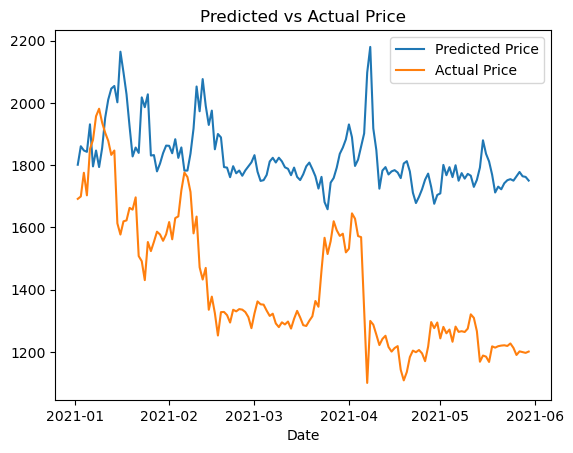

In [49]:
plt.plot(df.index, df['predicted_price']*10000, label='Predicted Price')
plt.plot(df.index, df['actual_price']*10000, label='Actual Price')

# Add x-axis label and titl
plt.xlabel('Date')
plt.title('Predicted vs Actual Price')

# Add legend and show the plot
plt.legend()
plt.show()

In [14]:
sentiment	pre_volu_eth	close_eth	previous_close_eth

SyntaxError: invalid syntax (2815023005.py, line 1)

In [15]:
max_volume = 84482912776

In [16]:
def get_digits(num):
    count = 0
    while(num > 0):
        num = num//10
        count = count + 1
    return count

def normalize(price, max_num): #gets a single coin's prices
    max_len_max_price = get_digits(max_num)
    return price/10**max_len_max_price

In [17]:
max_price = 4812.08740234375

In [36]:
advanced_test_data = pd.DataFrame([2.61, normalize(4796651246,max_volume), normalize(1907.8,max_price)])
advanced_test_data= advanced_test_data.T

In [37]:
predicted_price = model.predict(advanced_test_data) 

InvalidArgumentError: Graph execution error:

Detected at node 'model/dense/MatMul' defined at (most recent call last):
    File "C:\Users\MB-PC\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\MB-PC\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\MB-PC\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\MB-PC\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\MB-PC\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MB-PC\AppData\Local\Temp\ipykernel_10084\552486945.py", line 1, in <module>
      predicted_price = model.predict(advanced_test_data)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\MB-PC\anaconda3\lib\site-packages\keras\layers\core\dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'model/dense/MatMul'
Matrix size-incompatible: In[0]: [1,3], In[1]: [5,1]
	 [[{{node model/dense/MatMul}}]] [Op:__inference_predict_function_9220]